Using TensorFlow backend.


{'data_root': '/media/data/tanke/mvpose_data/cmu_panoptic',
 'nodes': [1, 15, 12, 3, 12, 14],
 'panels': [1, 6, 9, 14, 16, 19],
 'seq_name': '160422_ultimatum1'}
step 1: elapsed 2.2654740810394287
step 2: elapsed 0.01943039894104004
step 3: elapsed 0.3764917850494385
step 4: elapsed 3.083399534225464
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 0
	Inter:		 0
	Inter(choice):	 120
-------------------------------------------
	Time =  26  ms
	result: 0

	Total cost: 94.00789397258737

# valid points:		 123
# invalid points:	 17
step 5: elapsed 0.031084299087524414
(smart candidate selection) [
	Time =  4  ms
	result: 0

	Total cost: 27.664882632042463
] (smart candidate selection)
step 6: elapsed 0.021196842193603516

total elapsed: 5.7980406284332275
#Humans 4


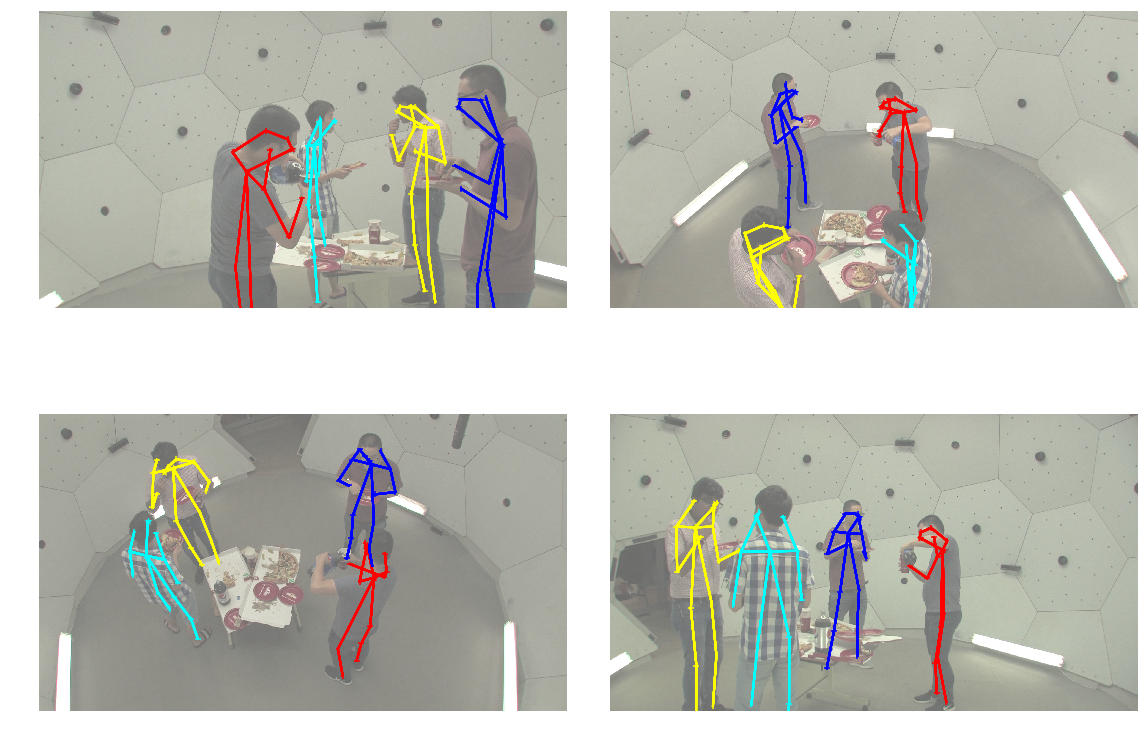

In [1]:
%matplotlib inline
# ---- settings ----
import json
from pprint import pprint
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time
from mvpose import settings

from mvpose.data import cmu_panoptic


params = settings.get_settings(
    max_epi_distance=40, 
    scale_to_mm=10, 
    gp_max_radius=50,
    pp_conflict_overlap=0.8)


root = Settings['CMU']['data_root']
tmp = Settings['tmp']

pprint(Settings['CMU'])

FRAME = 2000
FRAME = 8642
#FRAME = 3700
FRAME = 112


nodes = [0, 1, 2, 3]
panels = [0, 0, 0, 0]
#seq_name = '160422_ultimatum1'
#seq_name = '160224_haggling1'
#seq_name = '160422_mafia2'
seq_name = '160906_pizza1'


Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('cmu' + seq_name, 
                                                        Im, FRAME, 
                                                        with_gpu=True,
                                                        dir=tmp)


# ====================================
from mvpose import pose

_start = time()
Debug, detections = pose.estimate(
    Calib, heatmaps, pafs, settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)
# ====================================

from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

Humans = detections
print("#Humans", len(Humans))

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid], linewidth=2)
    
plt.tight_layout()
plt.show()

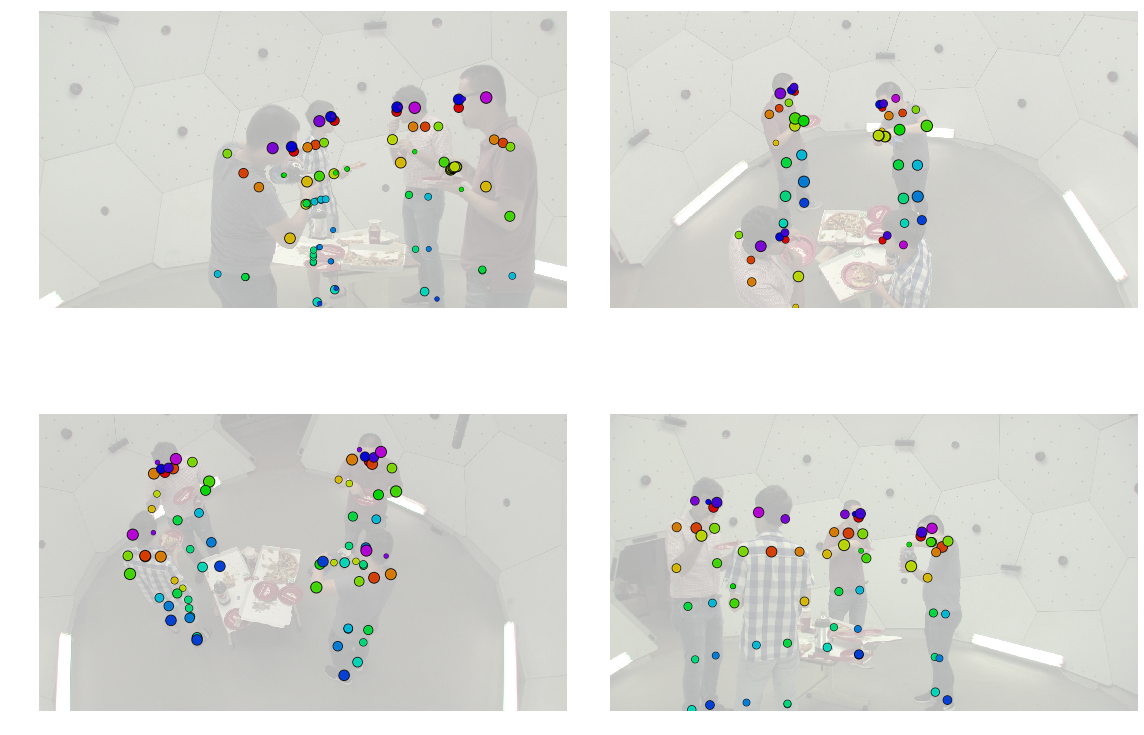

In [2]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.3)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*150, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*100, alpha=0.8)
    
plt.tight_layout()
plt.show()

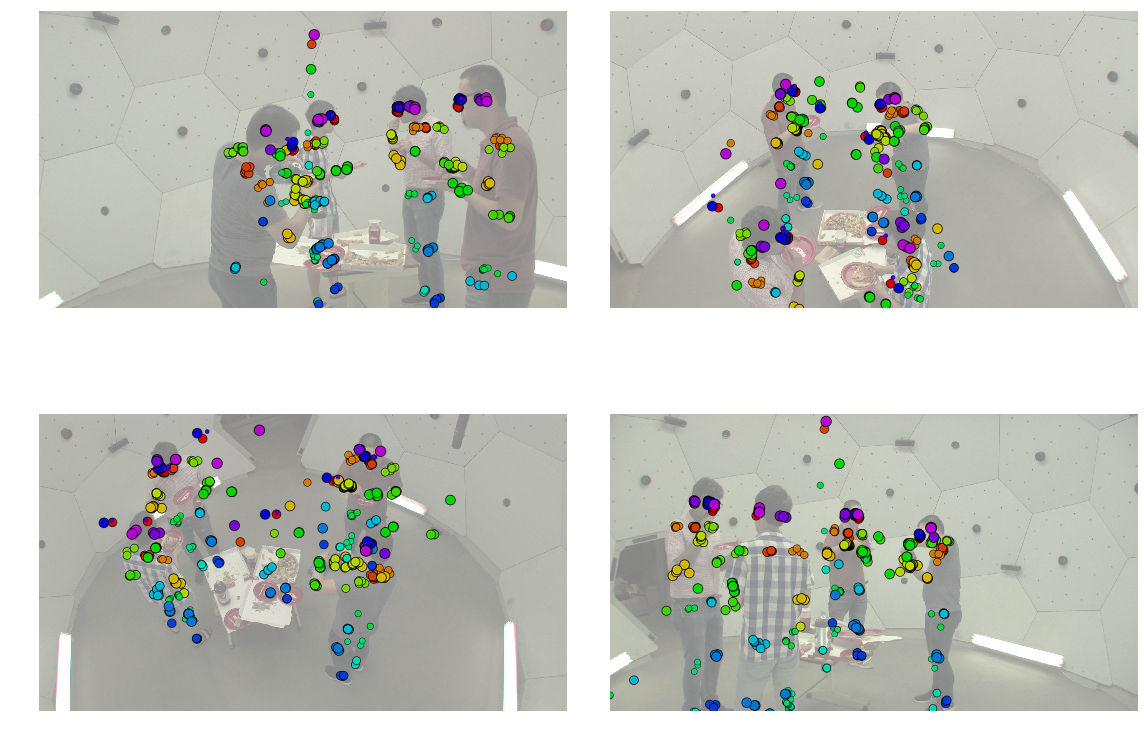

In [3]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*120, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*80, alpha=0.8)

plt.tight_layout()
plt.show()

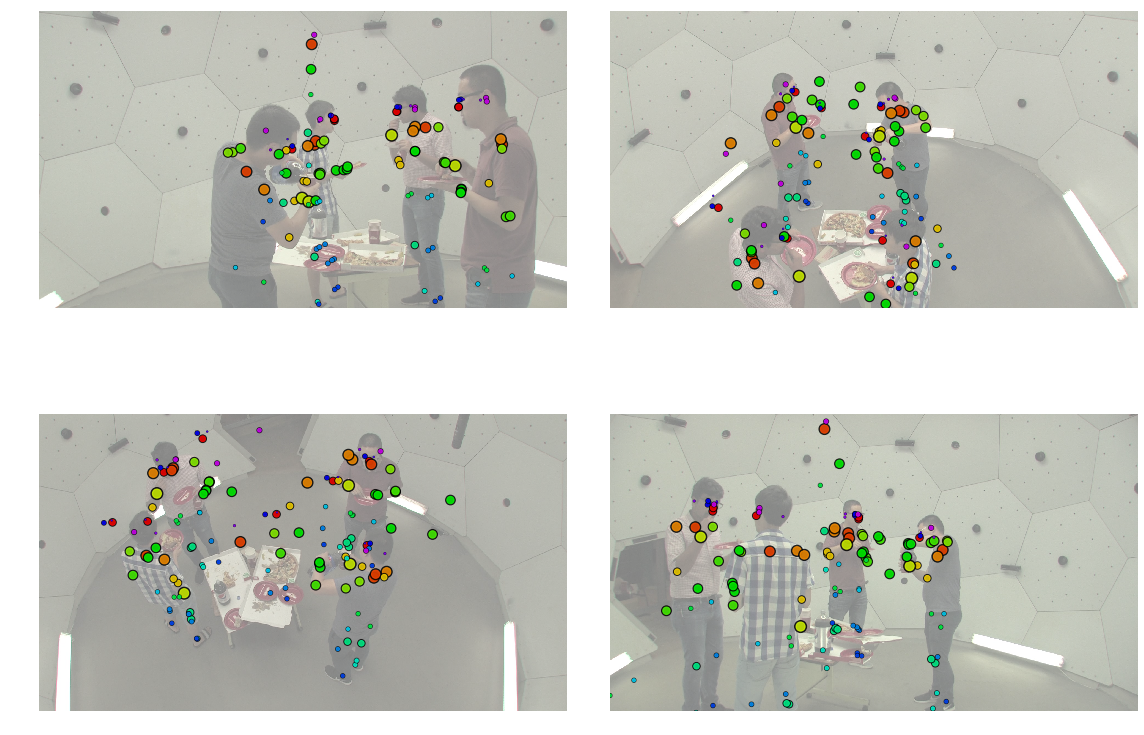

In [4]:
colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 2, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color='black', s=score*320/4, alpha=0.8)
                ax.scatter(x, y, color=colors[jid], s=score*180/4, alpha=0.8)

plt.tight_layout()
plt.show()

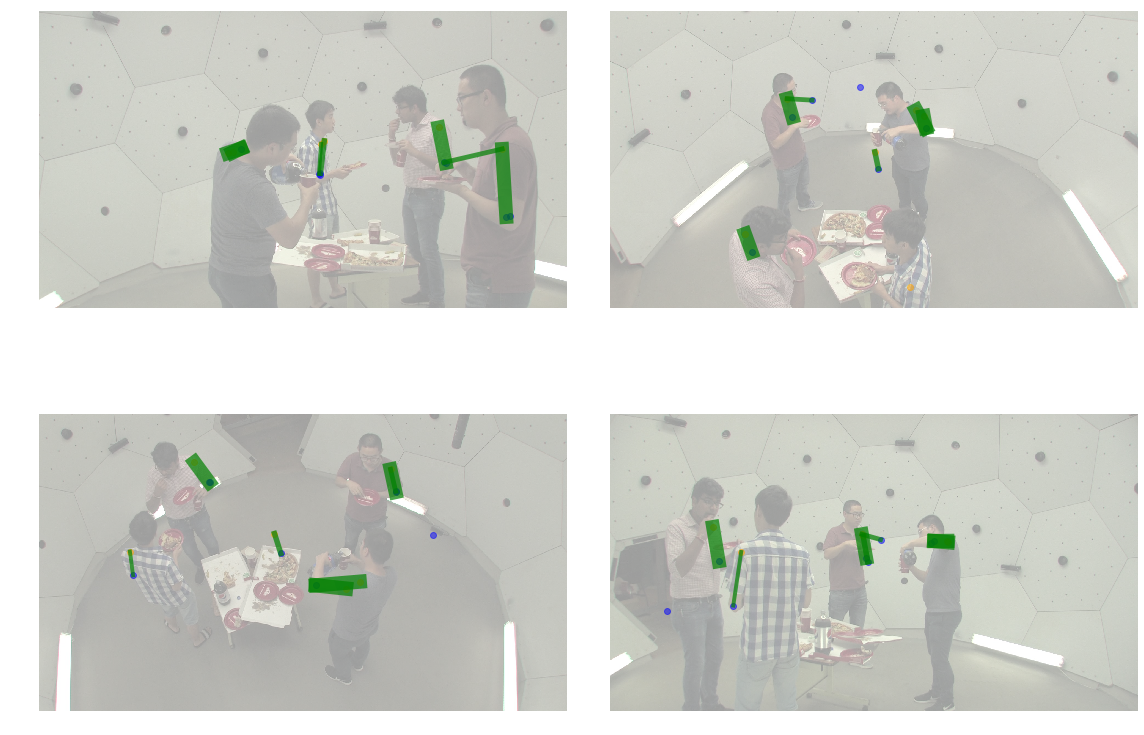

In [10]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 4
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    if len(maskA) == 0 or len(maskB) == 0:
        continue
    
    if len(maskA[0]) > 1:
        maskA = np.squeeze(maskA)
    if len(maskB[0]) > 1:
        maskB = np.squeeze(maskB)
        
    for _a in maskA:
        for _b in maskB:
            
            _a = np.squeeze(_a)
            _b = np.squeeze(_b)
            
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*40, alpha=0.7)
            elif w < 0:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*40, alpha=0.7)

plt.tight_layout()
plt.show()

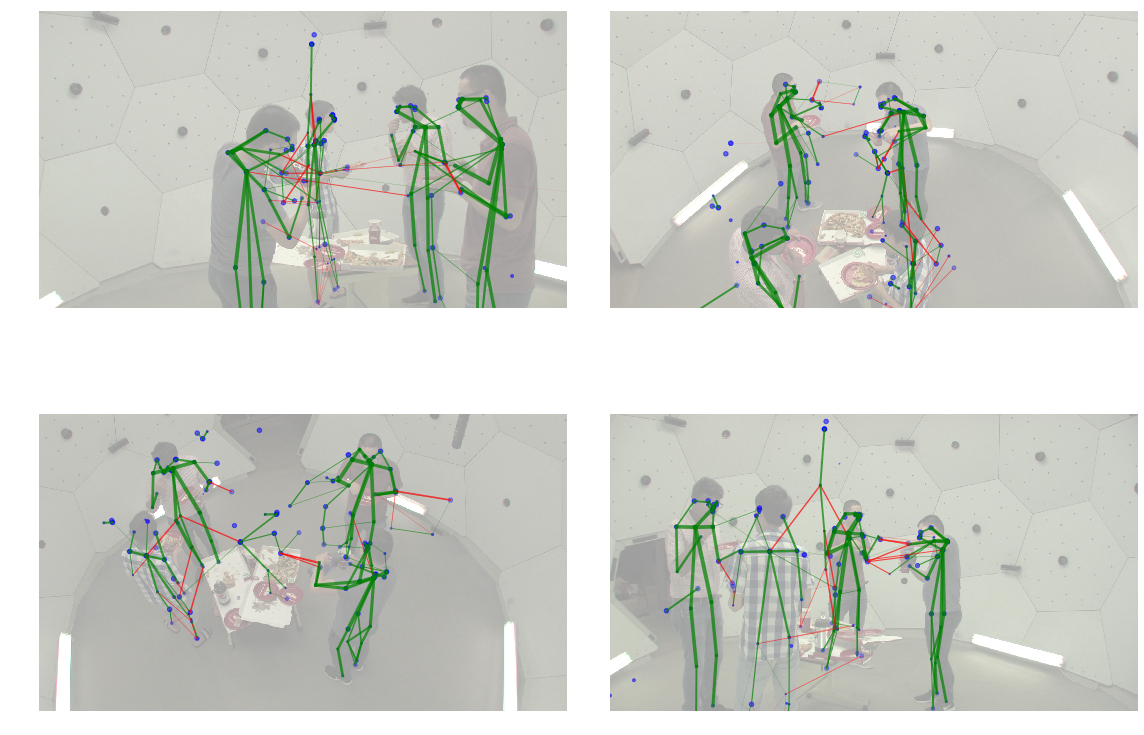

In [6]:
from mvpose.algorithm.graph_partitioning import get_unary

ALL_UNARIES = []
ALL_BINARIES = []
PBOOST_SMALL = lambda x: x

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
        unaryA = get_unary(Debug.triangulation.peaks3d_weighted[a])[maskA]
        #unaryA = unaryA/np.max(unaryA)
        unaryA = PBOOST_SMALL(np.clip(unaryA, a_min=0.00000001, a_max=0.99999999))
        unaryB = get_unary(Debug.triangulation.peaks3d_weighted[b])[maskB]
        #unaryB = unaryB/np.max(unaryB)
        
        unaryB = PBOOST_SMALL(np.clip(unaryB, 
                                      a_min=-0.99999999, 
                                      a_max=0.99999999))
        
        ALL_UNARIES.extend(unaryA)
        ALL_BINARIES.extend(unaryB)
        
        colorA = ['blue' if q > 0 else 'red' for q in unaryA]
        colorB = ['blue' if q > 0 else 'red' for q in unaryB]
        
        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color=colorA, alpha=0.3, s=np.abs(unaryA) * 20)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color=colorB, alpha=0.3, s=np.abs(unaryB) * 20)
        
        for _a in range(len(ptsA2d)):
            for _b in range(len(ptsB2d)):
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*9, alpha=0.7)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*9, alpha=0.7)

plt.tight_layout()
plt.show()

#humans 5


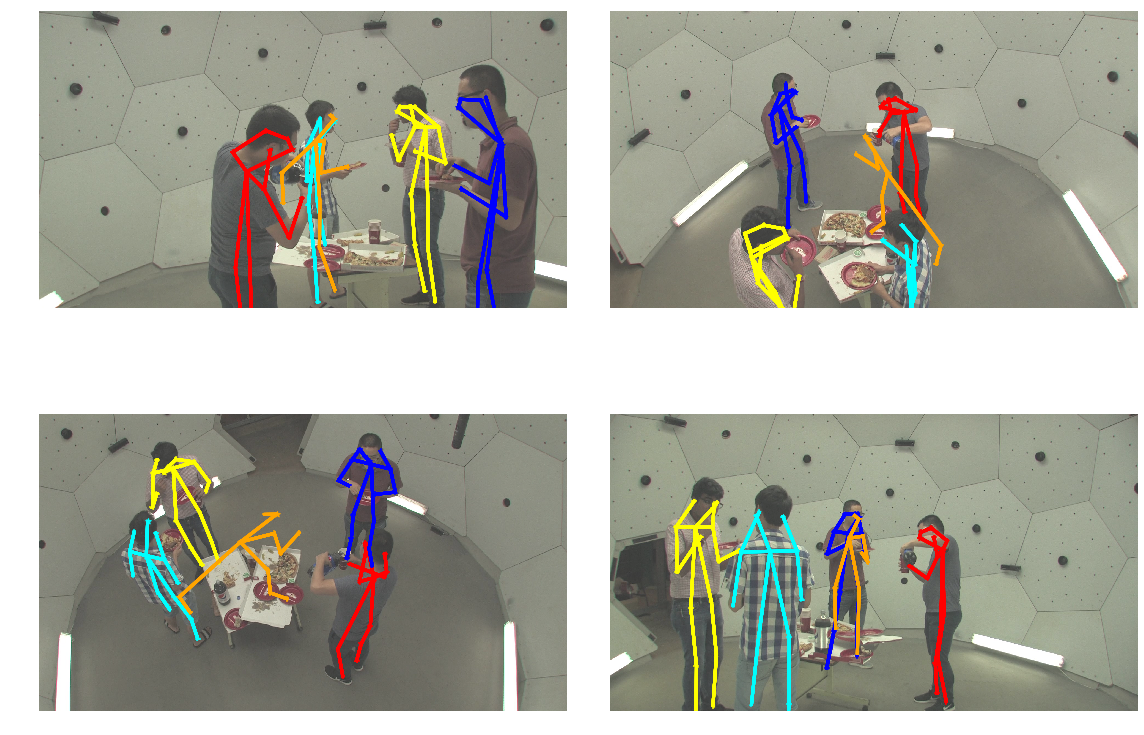

In [7]:
_Humans = Debug.graphcut.person_candidates
Humans = []
for human in _Humans:
    count = np.sum([0 if v is None else 1 for v in human])
    if count > 3:
        Humans.append(human)

fig = plt.figure(figsize=(16,12))

print('#humans', len(Humans))
colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 2,1+idx)
    ax.axis('off')
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
#     ax.set_ylim([330, 0])
#     if idx == 0:
#         ax.set_xlim([100, 500])
#     if idx == 1:
#         ax.set_xlim([100, 500])
#     if idx == 2:
#         ax.set_xlim([100, 500])
#     if idx == 3:
#         ax.set_xlim([120, 520])
    
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.8)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [8]:
gc = Debug.graphcut
iota_sums = gc.iota_sums
lambda_sums = gc.lambda_sums

ALL = []

for lid, sums in enumerate(lambda_sums):
    if len(sums) == 0:
        continue
    ALL += sums
    

print('avg:', np.mean(ALL))
print('std:', np.std(ALL))
print('min:', np.min(ALL))
print('max:', np.max(ALL))

avg: 0.6684900213297543
std: 0.6612852595827826
min: -0.7584611476158953
max: 2.1062992747975238


In [9]:
# avg: 0.9669985470869435
# std: 0.37136066198620926
# min: -0.06316830831129518
# max: 2.0439253983487435